In [217]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn


t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

linear_model = nn.Linear(1,1)

linear_model.weight
linear_model.bias

Parameter containing:
tensor([0.7619], requires_grad=True)

In [218]:
#for one sample
x = torch.ones(1)
linear_model(x)

#for many samples (the whole batch), the way it should be implemented
x = torch.ones(10,1)
linear_model(x)

tensor([[0.2517],
        [0.2517],
        [0.2517],
        [0.2517],
        [0.2517],
        [0.2517],
        [0.2517],
        [0.2517],
        [0.2517],
        [0.2517]], grad_fn=<AddmmBackward>)

In [219]:
print(t_u)
t_u.unsqueeze(1)

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])


tensor([[35.7000],
        [55.9000],
        [58.2000],
        [81.9000],
        [56.3000],
        [48.9000],
        [33.9000],
        [21.8000],
        [48.4000],
        [60.4000],
        [68.4000]])

In [220]:
#splitting the dataset for training/validation purposes
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)
t_un = t_u * 1e-1

n_samples = t_u.shape[0]
n_samples

#number of validation values
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)
shuffled_indices

train_indices = shuffled_indices[n_val:]
val_indices = shuffled_indices[:n_val]
print(train_indices, val_indices)

#applying the indices
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

#remember about normalizing
t_un_train = t_u_train * 1e-1
t_un_val = t_u_val * 1e-1

#unsqeezing for the nn module
t_un_val.unsqueeze_(1)
t_c_val.unsqueeze_(1)
t_un_train.unsqueeze_(1)
t_c_train.unsqueeze_(1)

tensor([ 2,  4, 10,  9,  8,  3,  7,  5,  0]) tensor([6, 1])


tensor([[[15.0000]],

        [[11.0000]],

        [[21.0000]],

        [[13.0000]],

        [[ 6.0000]],

        [[28.0000]],

        [[-4.0000]],

        [[ 8.0000]],

        [[ 0.5000]]])

In [221]:
#using linear model from nn

#adding model and loss as the arguments, no longer need to pass the parameters, since they will be initialized
#in the model
def training_loop_with_nn(n_epochs, optimizer, model, loss, t_u_train, t_c_train, t_u_val, t_c_val, do_print = True):
    
    for epoch in range(1, n_epochs+1):
        t_p_train = model(t_u_train)
        t_p_val = model(t_u_val)
        
        model_loss_train = loss(t_p_train, t_c_train)
        model_loss_val = loss(t_p_val, t_c_val)
        
        #backprop only for the train part of the data
        model_loss_train.backward()
        
        #update and zero the gradient
        optimizer.step()
        optimizer.zero_grad()
        
        if epoch in [1,2,3,n_epochs, n_epochs-1, n_epochs-2] and do_print == True:

            print(f"Epoch: {epoch}, TRAIN Loss value: {model_loss_train}")
            
            print(f"Epoch: {epoch}, VAL Loss value: {model_loss_val}")
            print("Params values: w = {}, b = {}".format(*model.parameters()))
        
    
    return list(model.parameters())

learning_rate = 1e-2
model = nn.Linear(1,1)

optimizer = optim.SGD(model.parameters(), lr=learning_rate) # we are passing the model parameters directly
loss = nn.MSELoss() #this time no need to define it separately

training_loop_with_nn(3000, optimizer, model, loss, t_un_train, t_c_train, t_un_val, t_c_val, do_print = True)

Epoch: 1, TRAIN Loss value: 279.8480529785156
Epoch: 1, VAL Loss value: 145.4254608154297
Params values: w = Parameter containing:
tensor([[1.2333]], requires_grad=True), b = Parameter containing:
tensor([0.6694], requires_grad=True)
Epoch: 2, TRAIN Loss value: 66.88665771484375
Epoch: 2, VAL Loss value: 22.42667579650879
Params values: w = Parameter containing:
tensor([[1.8634]], requires_grad=True), b = Parameter containing:
tensor([0.7434], requires_grad=True)
Epoch: 3, TRAIN Loss value: 39.52045822143555
Epoch: 3, VAL Loss value: 12.27638053894043
Params values: w = Parameter containing:
tensor([[2.0925]], requires_grad=True), b = Parameter containing:
tensor([0.7486], requires_grad=True)
Epoch: 2998, TRAIN Loss value: 2.6910383701324463
Epoch: 2998, VAL Loss value: 5.07450008392334
Params values: w = Parameter containing:
tensor([[5.5003]], requires_grad=True), b = Parameter containing:
tensor([-18.3810], requires_grad=True)
Epoch: 2999, TRAIN Loss value: 2.691035032272339
Epoch: 

[Parameter containing:
 tensor([[5.5004]], requires_grad=True),
 Parameter containing:
 tensor([-18.3813], requires_grad=True)]

In [222]:
#Multilayer perceptron using nn.Sequential
#essentially just changing the model in the previous function

#we are building the model with input layer, hidden layer (the Linear(1,13)) and output layer (Linear(13,1))
#nn.Tanh is the activation function after the hidden layer.
#the 13 is a number of features, it needs to be matched in both layers and it will be transformed to one output feature
seq_model = nn.Sequential(nn.Linear(1,13), nn.Tanh(), nn.Linear(13,1)) 

#look at the parameters
[params.shape for params in seq_model.parameters()]
#a better look at the parameters
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [223]:
#now create sequential model with layer names (easier inspection)

from collections import OrderedDict
seq_model = nn.Sequential(OrderedDict([('hidden_layer', nn.Linear(1,13)),('activation_function', nn.Tanh()),
                                       ('output_layer', nn.Linear(13,1))]))

for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_layer.weight torch.Size([13, 1])
hidden_layer.bias torch.Size([13])
output_layer.weight torch.Size([1, 13])
output_layer.bias torch.Size([1])


In [224]:
#getting to single parameter
print(seq_model.output_layer.bias)

Parameter containing:
tensor([0.0183], requires_grad=True)


In [225]:
model = seq_model
optimizer = optim.SGD(model.parameters(), lr=1e-3)
training_loop_with_nn(3000, optimizer, model, loss, t_un_train, t_c_train, t_un_val, t_c_val, do_print = True)

Epoch: 1, TRAIN Loss value: 220.52647399902344
Epoch: 1, VAL Loss value: 113.07725524902344
Params values: w = Parameter containing:
tensor([[ 0.0277],
        [-0.4856],
        [-0.5788],
        [ 0.8901],
        [ 0.9072],
        [-0.4965],
        [-0.6632],
        [-0.2944],
        [-0.5879],
        [-0.2201],
        [-0.9142],
        [ 0.3321],
        [-0.9263]], requires_grad=True), b = Parameter containing:
tensor([-0.6182, -0.4362, -0.4838,  0.0110,  0.8430,  0.1141,  0.8006,  0.7309,
        -0.5534,  0.2840, -0.9027, -0.9733, -0.3828], requires_grad=True)
Epoch: 2, TRAIN Loss value: 213.95864868164062
Epoch: 2, VAL Loss value: 108.14708709716797
Params values: w = Parameter containing:
tensor([[ 0.0188],
        [-0.4855],
        [-0.5788],
        [ 0.8901],
        [ 0.9072],
        [-0.4967],
        [-0.6632],
        [-0.2975],
        [-0.5879],
        [-0.2138],
        [-0.9142],
        [ 0.3305],
        [-0.9263]], requires_grad=True), b = Parameter co

[Parameter containing:
 tensor([[-0.2487],
         [-0.2693],
         [-0.2380],
         [ 0.7448],
         [ 0.8890],
         [-0.4153],
         [-0.4484],
         [-0.4913],
         [-0.2192],
         [-0.4380],
         [-0.8871],
         [ 0.5131],
         [-0.8342]], requires_grad=True),
 Parameter containing:
 tensor([ 0.0034,  0.2504, -0.0891, -0.0497,  0.8352,  2.3531,  2.8219,  3.2198,
         -0.3228,  1.9415, -0.8909, -3.4026, -0.3431], requires_grad=True),
 Parameter containing:
 tensor([[-1.9049, -1.8898, -1.6958,  1.3805,  1.3405, -3.2320, -3.1760, -3.6478,
          -1.5420, -2.7760, -1.7813,  3.7471, -1.8711]], requires_grad=True),
 Parameter containing:
 tensor([1.6074], requires_grad=True)]

In [226]:
print('output', seq_model(t_un_val))
print('answer', t_c_val)

output tensor([[[-0.3511]],

        [[10.9699]]], grad_fn=<AddBackward0>)
answer tensor([[[ 3.]],

        [[14.]]])


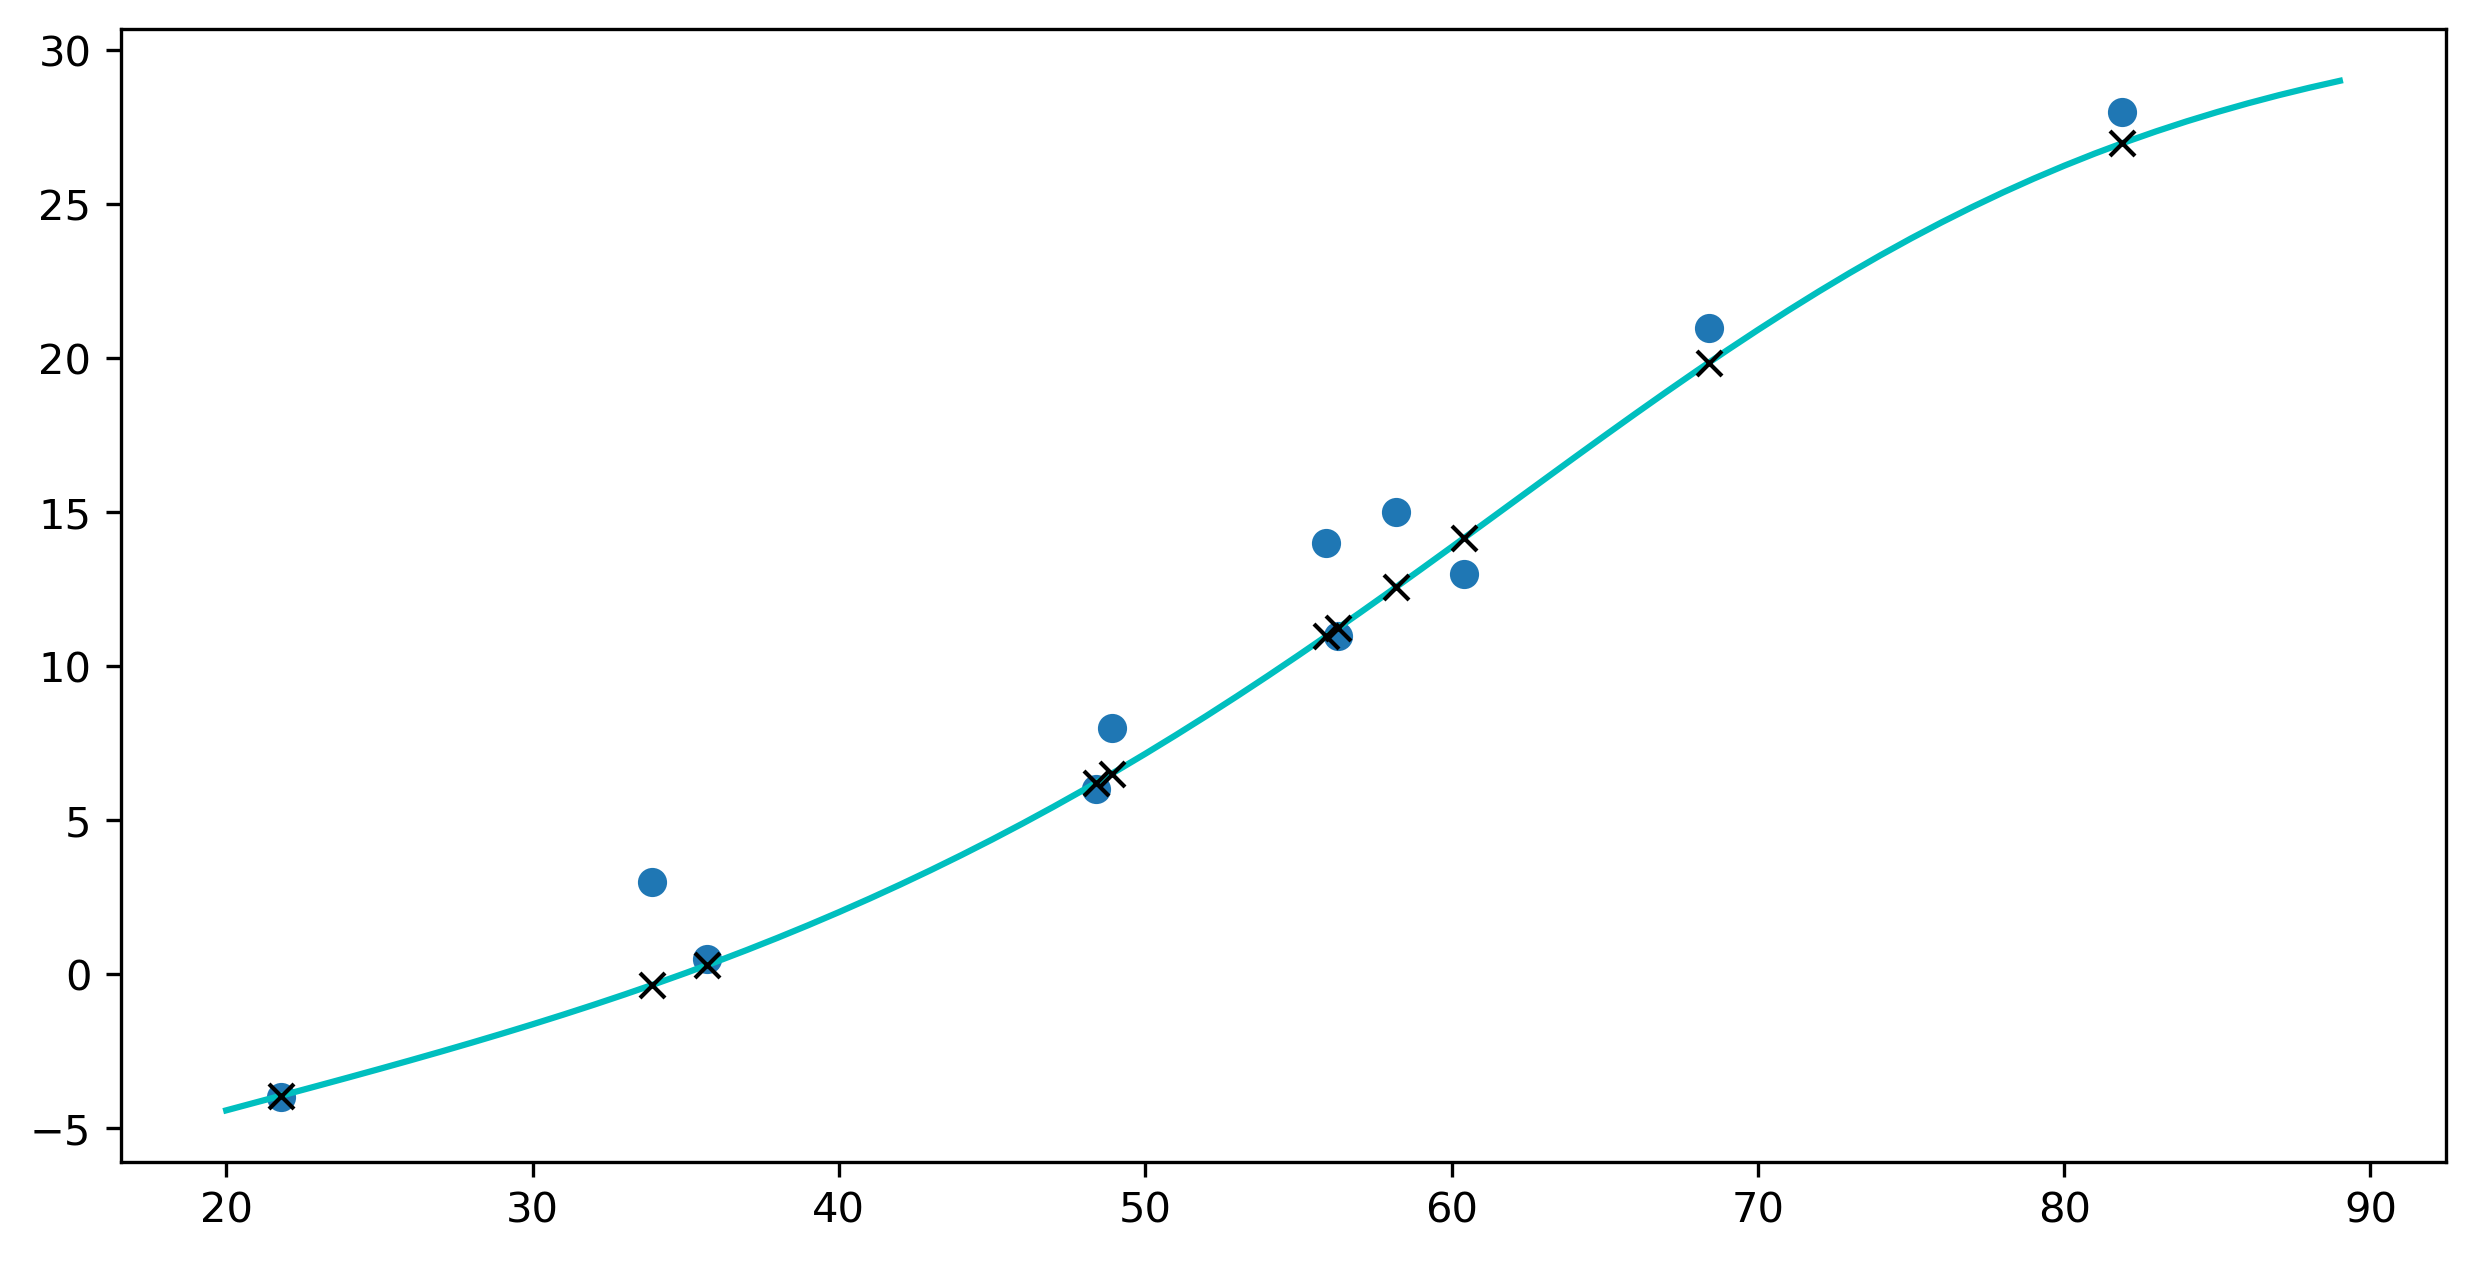

In [227]:
#comparison between nn.linear and first linear model

# fig = plt.figure(dpi = 300, figsize = (10,5))
# plt.plot(t_u, t_c, 'o')

# #the results are within the 20-90 range on x axis, so we will interpolate between
# print(network_range)


t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=300, figsize = (10, 5))
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model ( 0.1 * t_range).detach().numpy(), 'c-') #need to normalize with 0.1
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

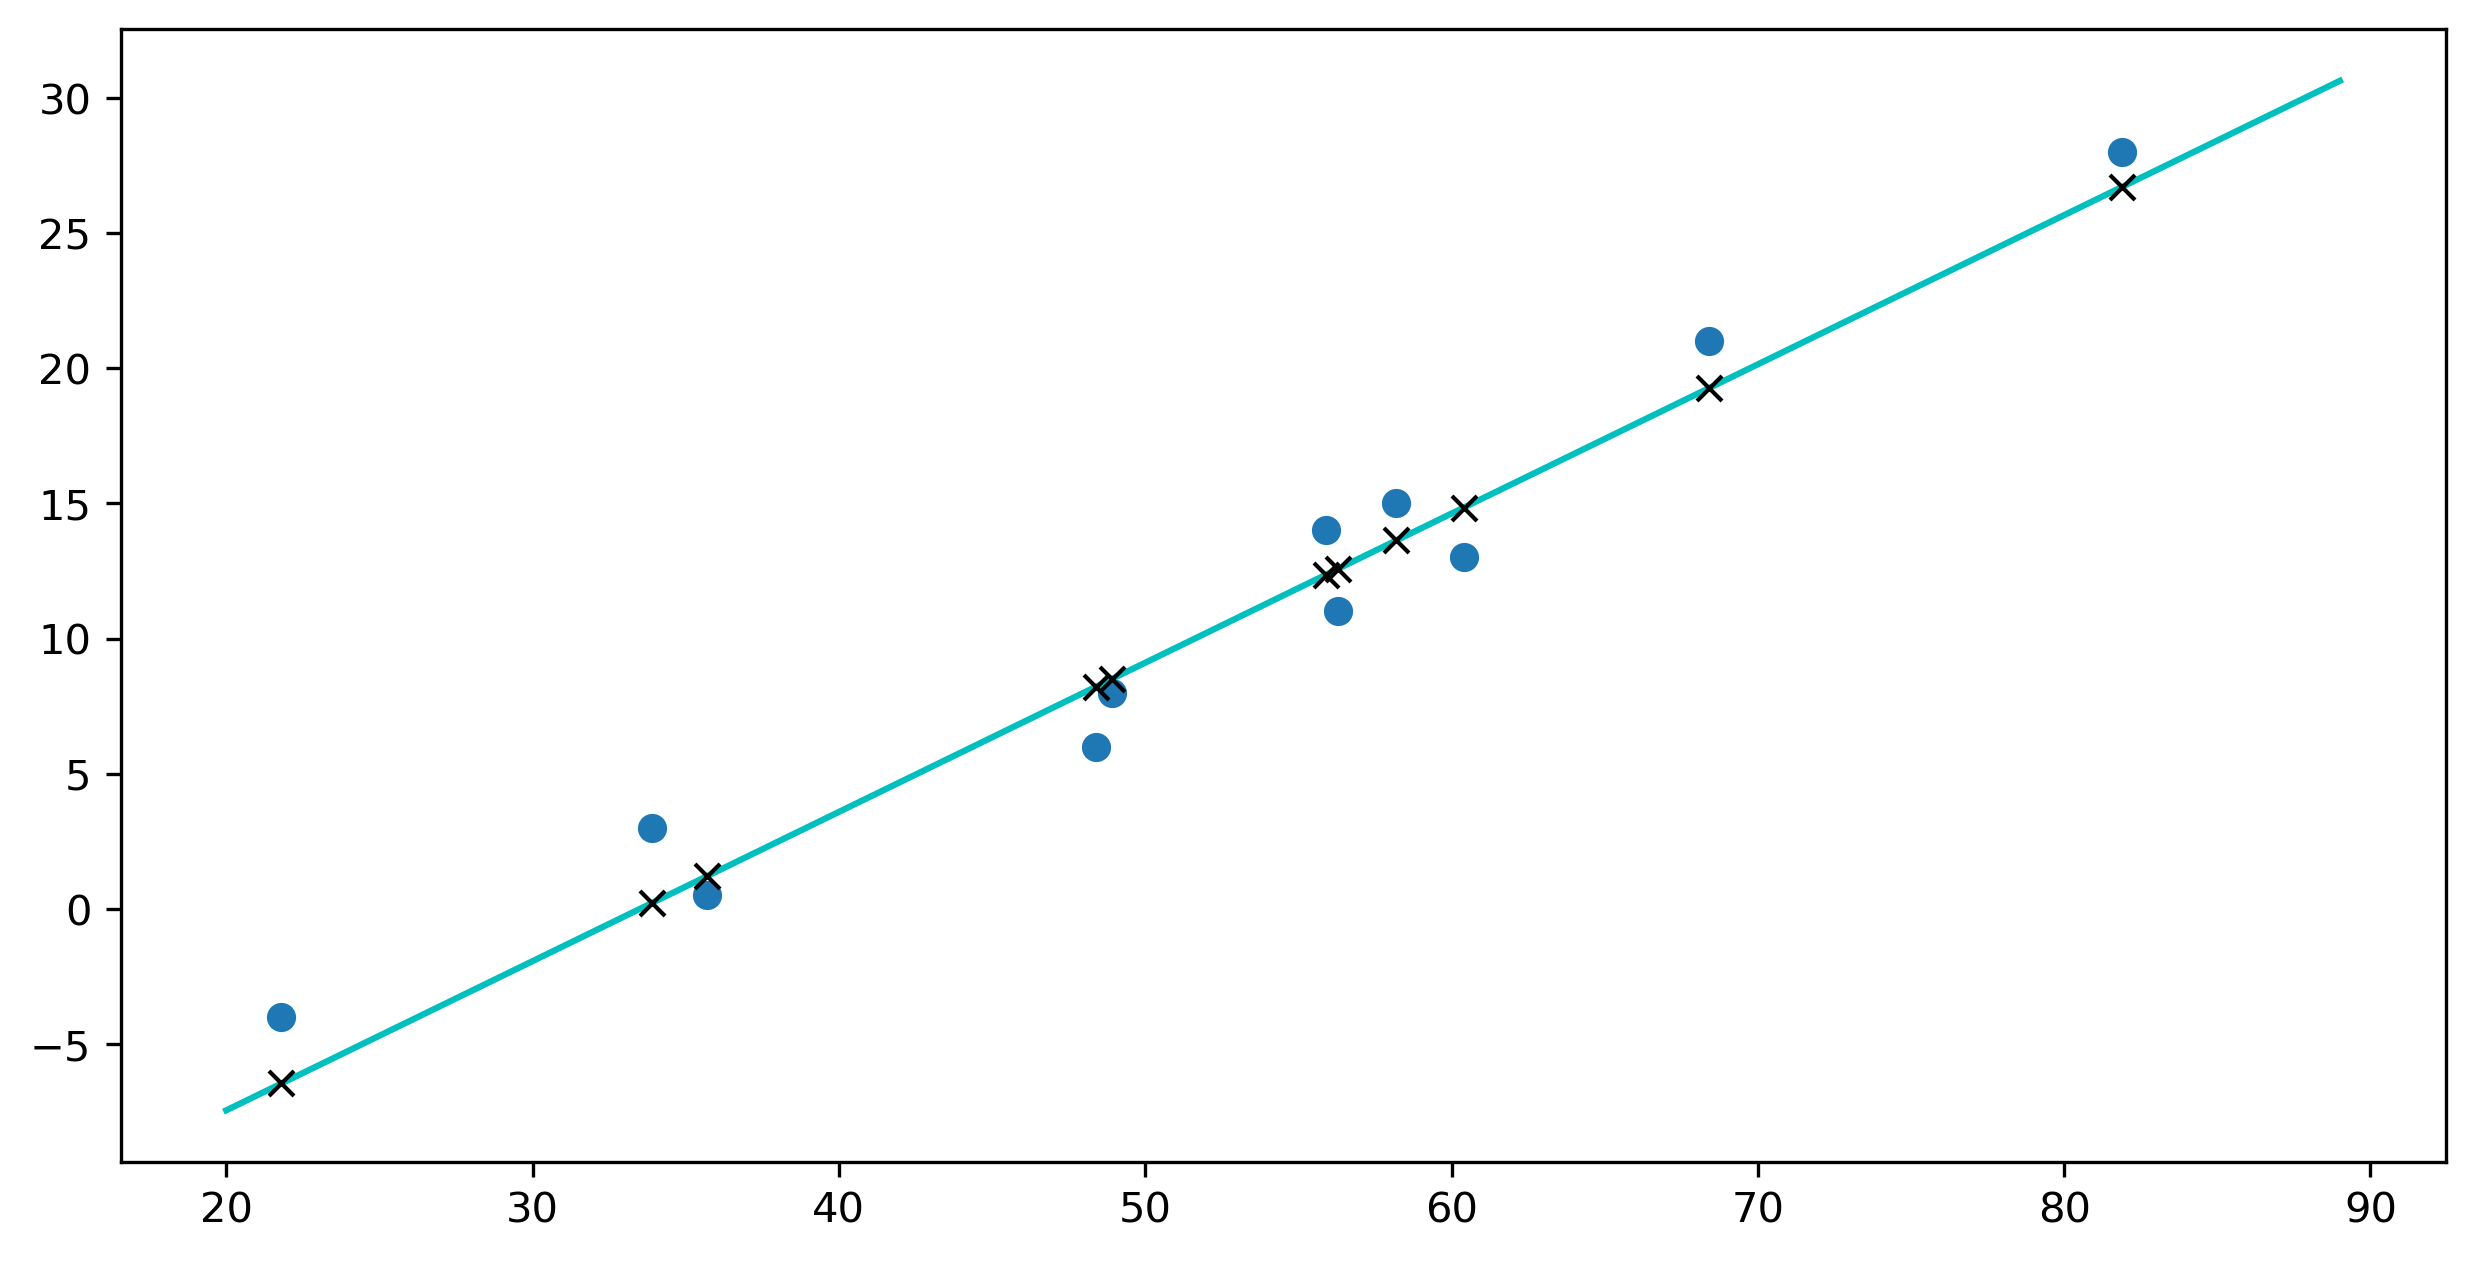

In [228]:
#### EXERCISES #####
#Q: What changes result in more linear output from the model?
#A: Removing the tanh activation function

model_small = nn.Sequential(nn.Linear(1,13), nn.Linear(13,1))
optimizer = optim.SGD(model_small.parameters(), lr=1e-3)
training_loop_with_nn(3000, optimizer, model_small, loss, t_un_train, t_c_train, t_un_val, t_c_val, do_print = False)


t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=300, figsize = (10, 5))
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), model_small( 0.1 * t_range).detach().numpy(), 'c-') #need to normalize with 0.1
plt.plot(t_u.numpy(), model_small(0.1 * t_u).detach().numpy(), 'kx')

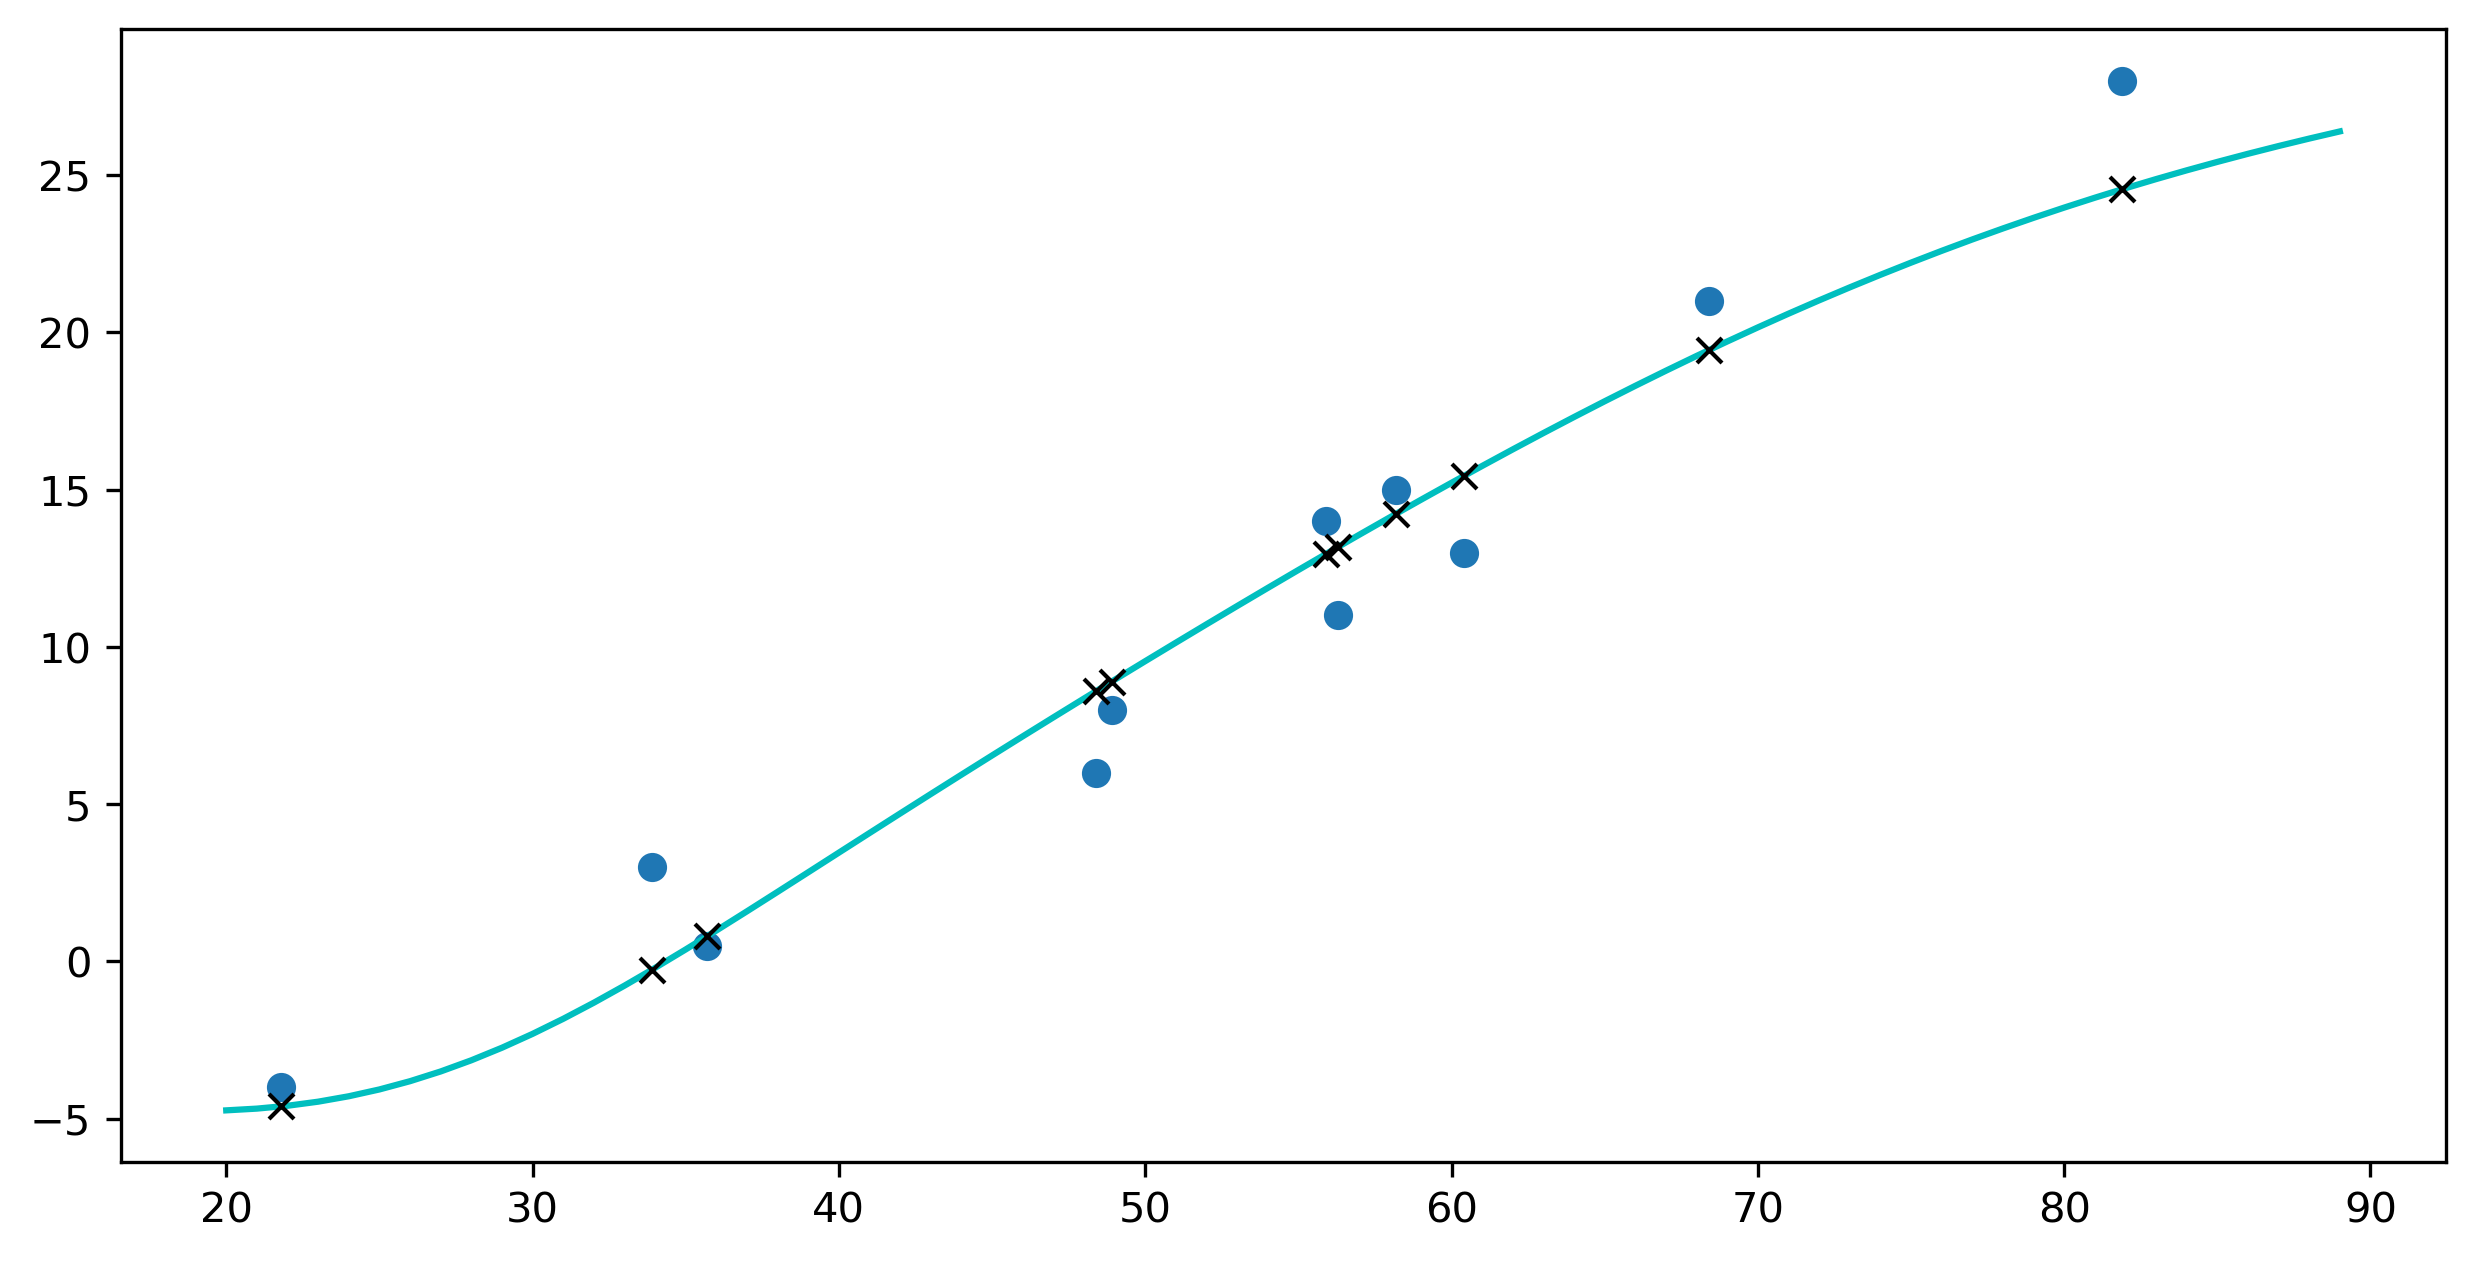

In [230]:
#Q: Can you get the model to obviously overfit the data?
#A: More neurons ?? other ideas??

model_small = nn.Sequential(nn.Linear(1,10), nn.Tanh(), nn.Linear(10, 10), nn.GELU(), nn.Linear(10,1))
optimizer = optim.Adam(model_small.parameters(), lr=1e-3)

training_loop_with_nn(1200, optimizer, model_small, loss, t_un, t_c, t_un_val, t_c_val, do_print = False)


t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=300, figsize = (10, 5))
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), model_small( 0.1 * t_range).detach().numpy(), 'c-') #need to normalize with 0.1
plt.plot(t_u.numpy(), model_small(0.1 * t_u).detach().numpy(), 'kx')